# NNGP kernel heuristics for MLP networks

In [1]:
from hypnettorch.data.special.regression1d_data import ToyRegression
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.spatial.distance import cdist
from sklearn.datasets import make_moons
from sklearn.gaussian_process.kernels import RBF
import sys
from time import time
import torch

# Pretend that notebook is located in base directory of this repo.
curr_dir = os.path.basename(os.path.abspath(os.curdir))
base_dir = os.path.abspath('../..')
if curr_dir == 'nngp' and base_dir != sys.path[0]:
    sys.path.insert(0, base_dir)

from nngp import MLPKernel

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = 'cpu'

In [2]:
def compute_kernels(data, config_dict):
    # Compute kernel matrices.
    for k in config_dict:
        start = time()
        if k['name'] == 'rbf':
            rbf_kernel = RBF()
            K = rbf_kernel(data.detach().cpu().numpy())
        else:
            mlp_kernel = MLPKernel(sigma2_w=1., sigma2_b=1., **k['params'])
            if k['name'].startswith('analytic'):
                K = mlp_kernel.kernel_analytic(data, **k['kernel_params']).numpy() 
            elif k['name'].startswith('efficient'):
                K = mlp_kernel.kernel_efficient(data, **k['kernel_params']).numpy()
            else:
                K = mlp_kernel.kernel_mc(data, **k['kernel_params']).numpy() 
        k['kernel'] = K
        print('Kernel "%s" computation took %f seconds.' % (k['name'], time()-start))

Code to investigate whether an NNGP kernel is stationary (i.e., translation invariant) such as an RBF kernel.

We consider it desirable if $k(x, x) = k(x', x')$ for any $x \neq x'$, as this implies that the prior 

In [3]:
def plot_stationarity_properties(kernel_dicts, num_bins=20):
    diag_K = [np.diagonal(k['kernel']) for k in kernel_dicts]
    min_K = min([np.min(K) for K in diag_K])
    max_K = max([np.max(K) for K in diag_K])
    bins = np.linspace(min_K-1., max_K+1., num_bins)
    for i, k in enumerate(kernel_dicts):
        plt.hist(diag_K[i], bins, alpha=.8, label=k['name'])
    plt.legend()
    plt.title('Histogram of kernel values k(x,x)')
    plt.show()

How does a kernel $k(x, x')$ behave in relation to the distance $\lVert x- x' \rVert_2$?

In [4]:
def kernel_val_vs_distance(data, kernel_dicts):
    if isinstance(data, torch.Tensor):
        data = data.detach().cpu().numpy()
    edits = cdist(data, data, metric='euclidean')
    triu_inds = np.triu_indices(edits.shape[0], k=1)
    triu_edits = edits[triu_inds]
    sorted_inds = np.argsort(triu_edits)

    plt.title('Kernel value vs Euclidean distance')
    for i, k in enumerate(kernel_dicts):
        plt.scatter(triu_edits[sorted_inds], k['kernel'][triu_inds][sorted_inds], label=k['name'])
    plt.legend()
    plt.ylabel('k(x, x\')')
    plt.xlabel('||x-x\'||')
    plt.show()

Compare analytically computed kernels to estimated kernels (e.g., via MC estimation).

In [5]:
def kernel_estimation_error(title, kernel_dicts, show_plots=True):
    # Note, `mc_size == -1` means the efficient kernel was used.
    K_dict = {}
    for d in kernel_dicts:
        if d['name'].startswith('analytic'):
            assert 0 not in K_dict.keys()
            K_dict[0] = d['kernel']
            
            nan_mask = np.isnan(d['kernel'])
            if np.any(nan_mask):
                print('%s has %d nan entries!' % (d['name'], nan_mask.sum()))
        elif d['name'].startswith('efficient'):
            assert -1 not in K_dict.keys()
            K_dict[-1] = d['kernel']
        else:
            assert 'num_samples' in d['kernel_params']
            num_mc = d['kernel_params']['num_samples']
            assert num_mc not in K_dict.keys()
            K_dict[num_mc] = d['kernel']

    err_dict = {}
    for k, v in K_dict.items():
        if k == 0:
            continue
        err_dict[k] = np.abs(K_dict[k] - K_dict[0])

    mc_sizes = list(err_dict.keys())
    mc_sizes.sort()
    err_means = [err_dict[n][~nan_mask].mean() for n in mc_sizes]
    err_stds = [err_dict[n][~nan_mask].std() for n in mc_sizes]
    
    if show_plots:
        plt.title(title)
        plt.errorbar(mc_sizes, err_means, yerr=err_stds, fmt='.k')
        plt.xscale('log')
        plt.show()

        for n in mc_sizes:
            plt.title(title + ' MC-%d' % n)
            plt.hist(K_dict[n].flatten())
            plt.show()
    
    return (mc_sizes, err_means, err_stds)

## 1D Cubic Regression

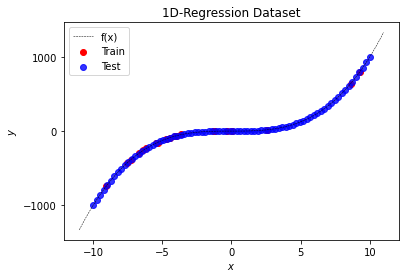

In [6]:
data = ToyRegression(train_inter=[-10, 10], num_train=20,
                     test_inter=[-10, 10], num_test=80, val_inter=None,
                     num_val=None, map_function=lambda x : (x**3.), std=3, rseed=42)
data.plot_dataset()

X_1dr_train_np = data.get_train_inputs()
X_1dr_train = data.input_to_torch_tensor(X_1dr_train_np, device=device)

In [7]:
kernels = [
    ######################
    ### Common Kernels ###
    ######################
    {'name': 'rbf'},
    ####################
    ### NNGP Kernels ###
    ####################
    ### Relu ###
    {'name': 'relu_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'relu_2l', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'relu_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'relu_8l', 'params': {'n_layer': 8, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'relu_16l', 'params': {'n_layer': 16, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'relu_1l_mc100', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100}},
    {'name': 'relu_2l_mc100', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100}},
    {'name': 'relu_4l_mc100', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100}},
    {'name': 'relu_1l_mc10k', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 10000}},
    {'name': 'relu_2l_mc10k', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 10000}},
    {'name': 'relu_4l_mc10k', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 10000}},
    {'name': 'relu_1l_mc100k', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100000}},
    {'name': 'relu_2l_mc100k', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100000}},
    {'name': 'relu_4l_mc100k', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100000}},
    {'name': 'analytic_relu_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'analytic_relu_2l', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'analytic_relu_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    #{'name': 'relu_1l_seq', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
    # 'kernel_params': {'num_samples': 1000, 'parallel_comp': False}},
    #{'name': 'relu_4l_seq', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
    # 'kernel_params': {'num_samples': 1000, 'parallel_comp': False}},
    #{'name': 'analytic_osp1_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
    # 'kernel_params': {'nl_type': 'one_sided_poly_1'}},
    #{'name': 'analytic_osp1_2l', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
    # 'kernel_params': {'nl_type': 'one_sided_poly_1'}},
    ### Sigmoid ###
    {'name': 'sigmoid_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.Sigmoid()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'sigmoid_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.Sigmoid()},
     'kernel_params': {'num_samples': 1000}},
    ### Tanh ###
    {'name': 'tanh_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.Tanh()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'tanh_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.Tanh()},
     'kernel_params': {'num_samples': 1000}},
    ### Error Function ###
    {'name': 'erf_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'erf_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'erf_1l_mc100k', 'params': {'n_layer': 1, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 100000}},
    {'name': 'erf_4l_mc100k', 'params': {'n_layer': 4, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 100000}},
    {'name': 'analytic_erf_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.erf},
     'kernel_params': {}},
    {'name': 'analytic_erf_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.erf},
     'kernel_params': {}},
    ### Cosine ###
    {'name': 'analytic_cos_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.cos},
     'kernel_params': {}},
    {'name': 'cos_1l_mc100', 'params': {'n_layer': 1, 'nonlinearity': torch.cos},
     'kernel_params': {'num_samples': 100}},
    {'name': 'cos_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.cos},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'cos_1l_mc10k', 'params': {'n_layer': 1, 'nonlinearity': torch.cos},
     'kernel_params': {'num_samples': 10000}},
    {'name': 'cos_1l_mc100k', 'params': {'n_layer': 1, 'nonlinearity': torch.cos},
     'kernel_params': {'num_samples': 100000}},
    
    {'name': 'cos_2l', 'params': {'n_layer': 2, 'nonlinearity': torch.cos},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'cos_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.cos},
     'kernel_params': {'num_samples': 1000}},
]

kernels_1dr = [dict(k) for k in kernels]

compute_kernels(X_1dr_train, kernels_1dr)

Kernel "rbf" computation took 0.000240 seconds.
Kernel "relu_1l" computation took 0.007610 seconds.
Kernel "relu_2l" computation took 0.010929 seconds.
Kernel "relu_4l" computation took 0.019352 seconds.
Kernel "relu_8l" computation took 0.041421 seconds.
Kernel "relu_16l" computation took 0.069971 seconds.
Kernel "relu_1l_mc100" computation took 0.001041 seconds.
Kernel "relu_2l_mc100" computation took 0.006186 seconds.
Kernel "relu_4l_mc100" computation took 0.012140 seconds.
Kernel "relu_1l_mc10k" computation took 0.006601 seconds.
Kernel "relu_2l_mc10k" computation took 0.014998 seconds.
Kernel "relu_4l_mc10k" computation took 0.034120 seconds.
Kernel "relu_1l_mc100k" computation took 0.060722 seconds.
Kernel "relu_2l_mc100k" computation took 0.123191 seconds.
Kernel "relu_4l_mc100k" computation took 0.246331 seconds.
Kernel "analytic_relu_1l" computation took 0.000662 seconds.
Kernel "analytic_relu_2l" computation took 0.000316 seconds.
Kernel "analytic_relu_4l" computation took 0

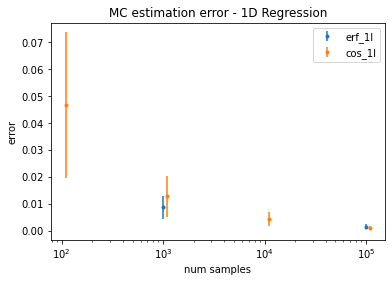

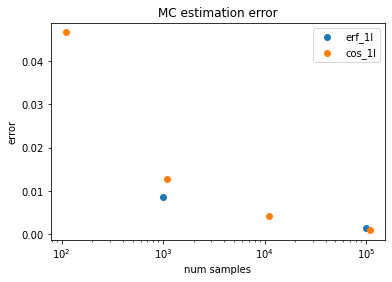

In [8]:
kernels_relu_1l = [k for k in kernels_1dr if 'relu_1l' in k['name']]
relu_1l_errs = kernel_estimation_error('relu_1l', kernels_relu_1l, show_plots=False)

kernels_relu_2l = [k for k in kernels_1dr if 'relu_2l' in k['name']]
relu_2l_errs = kernel_estimation_error('relu_2l', kernels_relu_2l, show_plots=False)

kernels_relu_4l = [k for k in kernels_1dr if 'relu_4l' in k['name']]
relu_4l_errs = kernel_estimation_error('relu_4l', kernels_relu_4l, show_plots=False)

kernels_erf_1l = [k for k in kernels_1dr if 'erf_1l' in k['name']]
erf_1l_errs = kernel_estimation_error('erf_1l', kernels_erf_1l, show_plots=False)

kernels_erf_4l = [k for k in kernels_1dr if 'erf_4l' in k['name']]
erf_4l_errs = kernel_estimation_error('erf_4l', kernels_erf_4l, show_plots=False)

kernels_cos_1l = [k for k in kernels_1dr if 'cos_1l' in k['name']]
cos_1l_errs = kernel_estimation_error('cos_1l', kernels_cos_1l, show_plots=False)


errs = [('relu_1l', relu_1l_errs), ('relu_2l', relu_2l_errs), ('relu_4l', relu_4l_errs)]
errs = [('erf_1l', erf_1l_errs), ('erf_4l', erf_4l_errs)]
errs = [('erf_1l', erf_1l_errs), ('cos_1l', cos_1l_errs)]

plt.title('MC estimation error - 1D Regression')
for i, err in enumerate(errs):
    sizes = [s + i*s/10 for s in err[1][0]]
    plt.errorbar(sizes, err[1][1], yerr=err[1][2], label=err[0], fmt='.')
plt.xscale('log')
plt.xlabel('num samples')
plt.ylabel('error')
plt.legend()
plt.show()

plt.title('MC estimation error')
for i, err in enumerate(errs):
    sizes = [s + i*s/10 for s in err[1][0]]
    plt.scatter(sizes, err[1][1], label=err[0])
plt.xscale('log')
plt.xlabel('num samples')
plt.ylabel('error')
plt.legend()
plt.show()

In [9]:
#plot_stationarity_properties(kernels_1dr, num_bins=20)
#kernel_val_vs_distance(X_1dr_train, kernels_1dr)

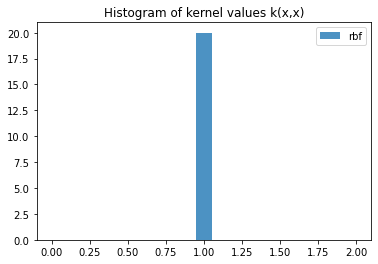

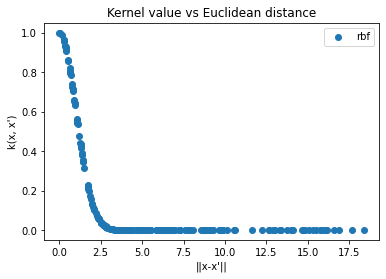

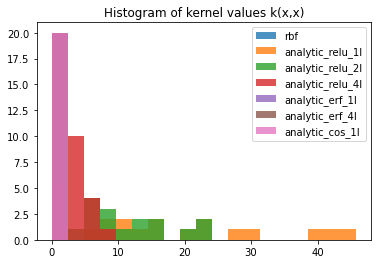

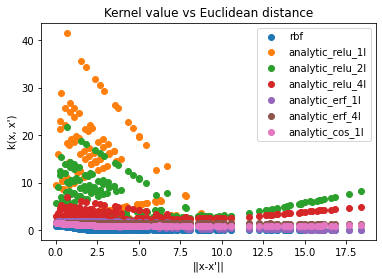

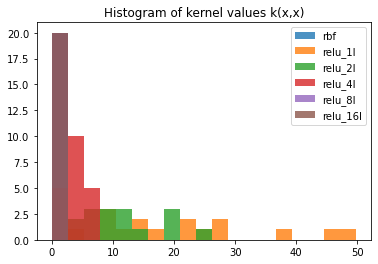

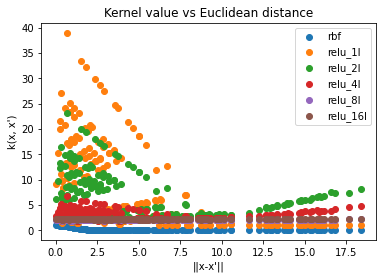

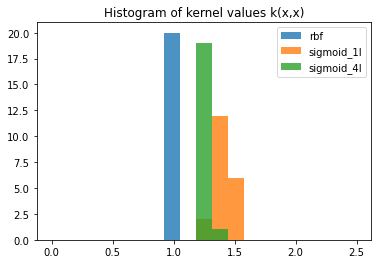

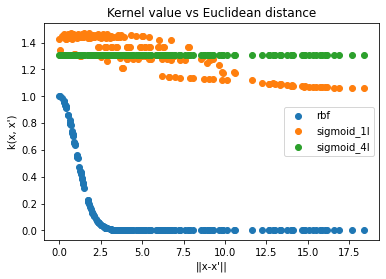

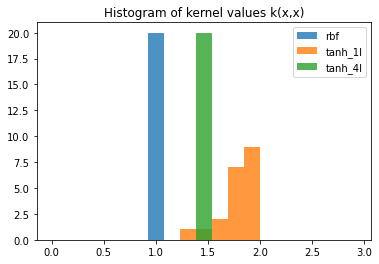

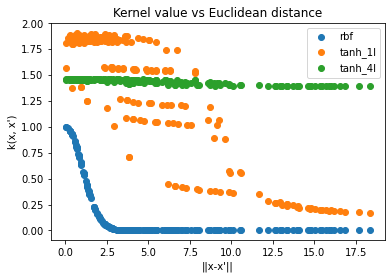

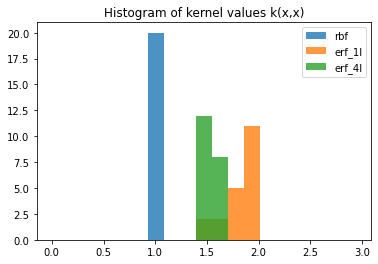

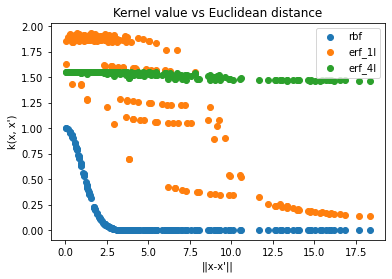

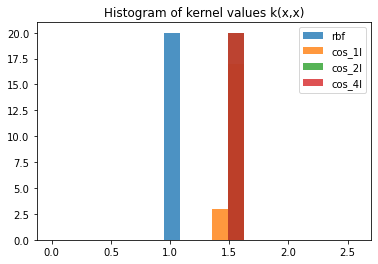

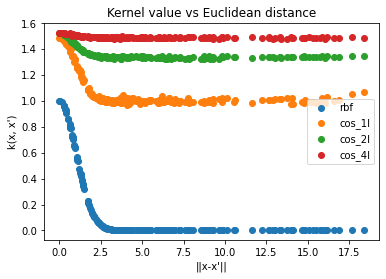

In [10]:
kernels_tmp = [k for k in kernels_1dr if k['name'] in ['rbf']]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_1dr_train, kernels_tmp)

kernels_tmp = [k for k in kernels_1dr if k['name'] in ['rbf'] or k['name'].startswith('analytic')]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_1dr_train, kernels_tmp)

kernels_tmp = [k for k in kernels_1dr if k['name'] in ['rbf'] or \
               (k['name'].startswith('relu') and k['kernel_params']['num_samples'] == 1000)]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_1dr_train, kernels_tmp)

kernels_tmp = [k for k in kernels_1dr if k['name'] in ['rbf'] or k['name'].startswith('sigmoid')]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_1dr_train, kernels_tmp)

kernels_tmp = [k for k in kernels_1dr if k['name'] in ['rbf'] or k['name'].startswith('tanh')]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_1dr_train, kernels_tmp)

kernels_tmp = [k for k in kernels_1dr if k['name'] in ['rbf'] or \
               (k['name'].startswith('erf') and k['kernel_params']['num_samples'] == 1000)]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_1dr_train, kernels_tmp)

kernels_tmp = [k for k in kernels_1dr if k['name'] in ['rbf'] or \
               (k['name'].startswith('cos') and k['kernel_params']['num_samples'] == 1000)]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_1dr_train, kernels_tmp)

## Two Moons Dataset

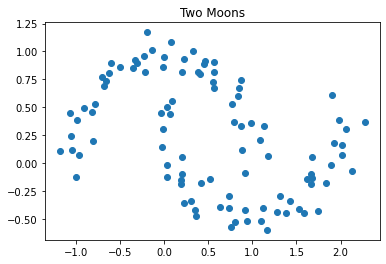

In [11]:
X, Y = make_moons(n_samples=100, shuffle=True, noise=.1, random_state=42)

plt.title('Two Moons')
plt.scatter(X[:,0], X[:,1])
plt.show()

In [12]:
X_moon = torch.Tensor(X).to(device)
kernels_moon = [dict(k) for k in kernels]
compute_kernels(X_moon, kernels_moon)

Kernel "rbf" computation took 0.000240 seconds.
Kernel "relu_1l" computation took 0.023732 seconds.
Kernel "relu_2l" computation took 0.042293 seconds.
Kernel "relu_4l" computation took 0.076811 seconds.
Kernel "relu_8l" computation took 0.161389 seconds.
Kernel "relu_16l" computation took 0.318155 seconds.
Kernel "relu_1l_mc100" computation took 0.002657 seconds.
Kernel "relu_2l_mc100" computation took 0.009426 seconds.
Kernel "relu_4l_mc100" computation took 0.024738 seconds.
Kernel "relu_1l_mc10k" computation took 0.116352 seconds.
Kernel "relu_2l_mc10k" computation took 0.235783 seconds.
Kernel "relu_4l_mc10k" computation took 0.470926 seconds.
Kernel "relu_1l_mc100k" computation took 1.072600 seconds.
Kernel "relu_2l_mc100k" computation took 2.145378 seconds.
Kernel "relu_4l_mc100k" computation took 4.294097 seconds.
Kernel "analytic_relu_1l" computation took 0.000575 seconds.
Kernel "analytic_relu_2l" computation took 0.000492 seconds.
Kernel "analytic_relu_4l" computation took 0

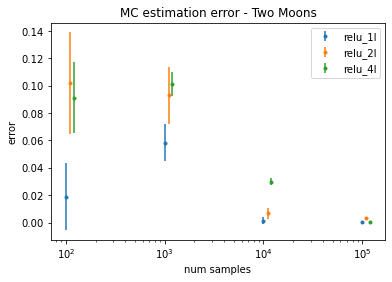

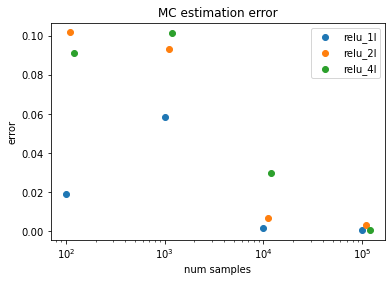

In [13]:
kernels_relu_1l = [k for k in kernels_moon if 'relu_1l' in k['name']]
relu_1l_errs = kernel_estimation_error('relu_1l', kernels_relu_1l, show_plots=False)

kernels_relu_2l = [k for k in kernels_moon if 'relu_2l' in k['name']]
relu_2l_errs = kernel_estimation_error('relu_2l', kernels_relu_2l, show_plots=False)

kernels_relu_4l = [k for k in kernels_moon if 'relu_4l' in k['name']]
relu_4l_errs = kernel_estimation_error('relu_4l', kernels_relu_4l, show_plots=False)

errs = [('relu_1l', relu_1l_errs), ('relu_2l', relu_2l_errs), ('relu_4l', relu_4l_errs)]

plt.title('MC estimation error - Two Moons')
for i, err in enumerate(errs):
    sizes = [s + i*s/10 for s in err[1][0]]
    plt.errorbar(sizes, err[1][1], yerr=err[1][2], label=err[0], fmt='.')
plt.xscale('log')
plt.xlabel('num samples')
plt.ylabel('error')
plt.legend()
plt.show()

plt.title('MC estimation error')
for i, err in enumerate(errs):
    sizes = [s + i*s/10 for s in err[1][0]]
    plt.scatter(sizes, err[1][1], label=err[0])
plt.xscale('log')
plt.xlabel('num samples')
plt.ylabel('error')
plt.legend()
plt.show()

In [14]:
#plot_stationarity_properties(kernels_moon, num_bins=20)
#kernel_val_vs_distance(X_moon, kernels_moon)

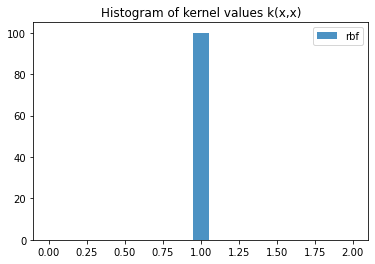

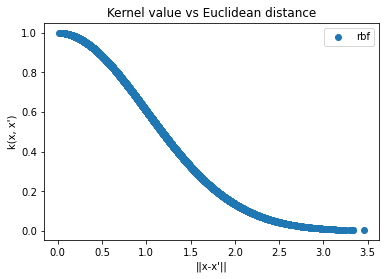

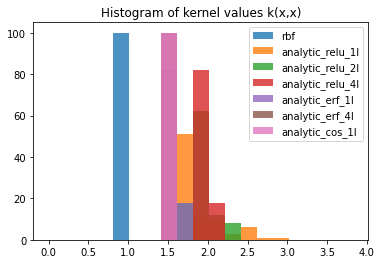

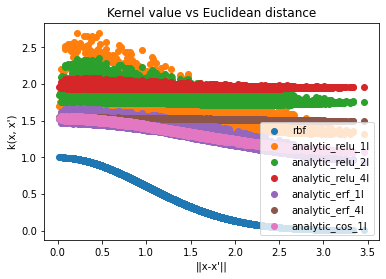

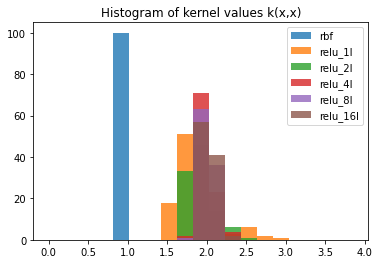

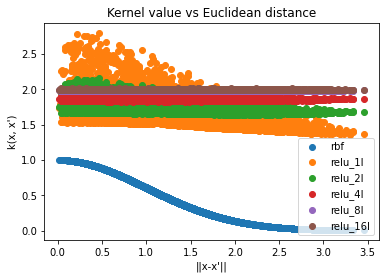

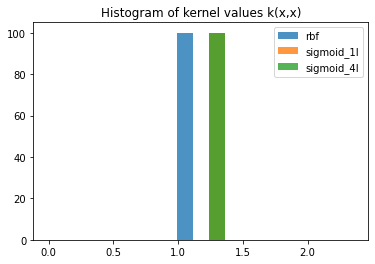

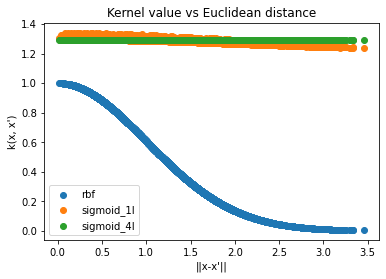

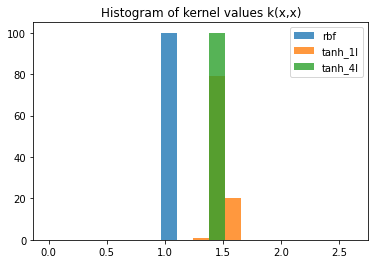

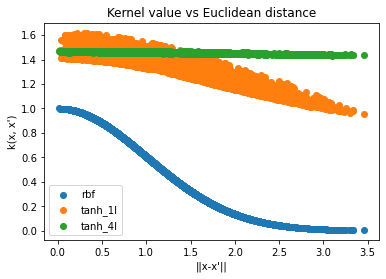

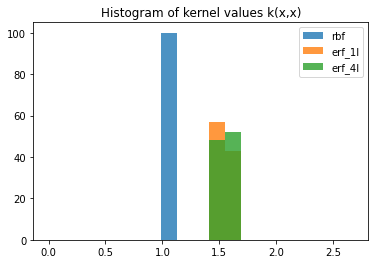

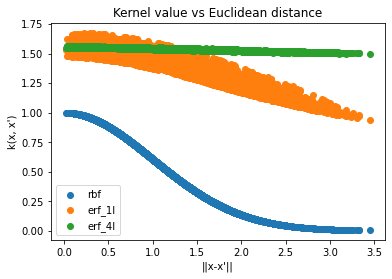

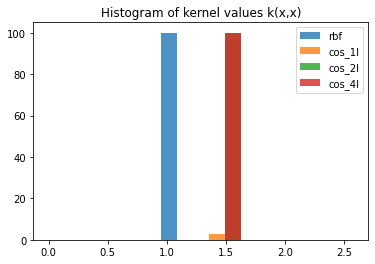

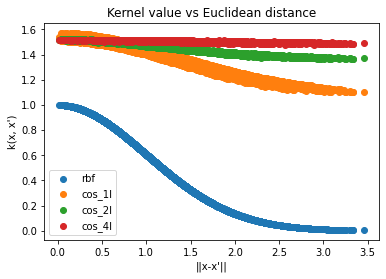

In [15]:
kernels_tmp = [k for k in kernels_moon if k['name'] in ['rbf']]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_moon, kernels_tmp)

kernels_tmp = [k for k in kernels_moon if k['name'] in ['rbf'] or k['name'].startswith('analytic')]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_moon, kernels_tmp)

kernels_tmp = [k for k in kernels_moon if k['name'] in ['rbf'] or \
               (k['name'].startswith('relu') and k['kernel_params']['num_samples'] == 1000)]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_moon, kernels_tmp)

kernels_tmp = [k for k in kernels_moon if k['name'] in ['rbf'] or k['name'].startswith('sigmoid')]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_moon, kernels_tmp)

kernels_tmp = [k for k in kernels_moon if k['name'] in ['rbf'] or k['name'].startswith('tanh')]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_moon, kernels_tmp)

kernels_tmp = [k for k in kernels_moon if k['name'] in ['rbf'] or \
               (k['name'].startswith('erf') and k['kernel_params']['num_samples'] == 1000)]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_moon, kernels_tmp)

kernels_tmp = [k for k in kernels_moon if k['name'] in ['rbf'] or \
               (k['name'].startswith('cos') and k['kernel_params']['num_samples'] == 1000)]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_moon, kernels_tmp)

# Validate efficient kernel implementation

The original [NNGP paper](https://arxiv.org/pdf/1711.00165.pdf) proposes in Sec. 2.5 an efficient algorithm for kernel value approximation. This requires a certain data preprocessing (i.e., that all inputs have identical norm $\langle x, x \rangle = \langle x', x' \rangle$).

In the following, we consider a dataset that fulfills this criteria (random vectors on a sphere) and compare the efficiently computed kernel values (using a lookup table) to kernel values obtained via recursive MC estimates and/or analytically obtained kernel values (if applicable).

Input norms:  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


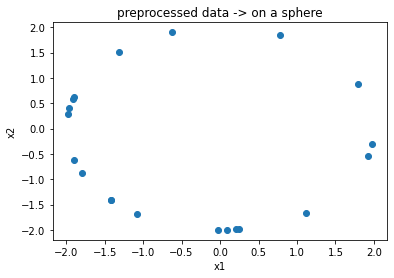

In [16]:
### Build dataset.
d_in = 2 # Input dimensionality
n = 20 # Num. samples

rs = np.random.RandomState(42)
X = rs.normal(size=(n, d_in))
#X = rs.rand(n, d_in) * rs.rand(n)[:, None]
X /= np.linalg.norm(X, axis=1)[:, None]
X *= d_in # Just an arbitrary design choice.
print('Input norms: ', np.sqrt(np.diag(X @ X.T)))

if d_in == 2:
    plt.title('preprocessed data -> on a sphere')
    plt.scatter(X[:,0], X[:,1])
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

In [17]:
X_sphere = torch.Tensor(X).to(device)

kernels_sphere = [
    ######################
    ### Common Kernels ###
    ######################
    {'name': 'rbf'},
    ####################
    ### NNGP Kernels ###
    ####################
    ### Relu ###
    {'name': 'relu_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'relu_2l', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'relu_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'relu_8l', 'params': {'n_layer': 8, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'relu_16l', 'params': {'n_layer': 16, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'relu_1l_mc100k', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100000}},
    {'name': 'relu_2l_mc100k', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100000}},
    {'name': 'relu_4l_mc100k', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100000}},
    {'name': 'relu_8l_mc100k', 'params': {'n_layer': 8, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100000}},
    {'name': 'relu_16l_mc100k', 'params': {'n_layer': 16, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100000}},
    {'name': 'analytic_relu_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'analytic_relu_2l', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'analytic_relu_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'analytic_relu_8l', 'params': {'n_layer': 8, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'analytic_relu_16l', 'params': {'n_layer': 16, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'efficient_relu_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'efficient_relu_2l', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'efficient_relu_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'efficient_relu_8l', 'params': {'n_layer': 8, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'efficient_relu_16l', 'params': {'n_layer': 16, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    ### Sigmoid ###
    {'name': 'sigmoid_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.Sigmoid()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'sigmoid_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.Sigmoid()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'efficient_sigmoid_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.Sigmoid()},
     'kernel_params': {}},
    {'name': 'efficient_sigmoid_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.Sigmoid()},
     'kernel_params': {}},
    ### Tanh ###
    {'name': 'tanh_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.Tanh()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'tanh_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.Tanh()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'efficient_tanh_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.Tanh()},
     'kernel_params': {}},
    {'name': 'efficient_tanh_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.Tanh()},
     'kernel_params': {}},
]

compute_kernels(X_sphere, kernels_sphere)

Kernel "rbf" computation took 0.000164 seconds.
Kernel "relu_1l" computation took 0.001817 seconds.
Kernel "relu_2l" computation took 0.006543 seconds.
Kernel "relu_4l" computation took 0.014829 seconds.
Kernel "relu_8l" computation took 0.024701 seconds.
Kernel "relu_16l" computation took 0.054835 seconds.
Kernel "relu_1l_mc100k" computation took 0.088731 seconds.
Kernel "relu_2l_mc100k" computation took 0.122868 seconds.
Kernel "relu_4l_mc100k" computation took 0.232733 seconds.
Kernel "relu_8l_mc100k" computation took 0.468649 seconds.
Kernel "relu_16l_mc100k" computation took 0.943135 seconds.
Kernel "analytic_relu_1l" computation took 0.000476 seconds.
Kernel "analytic_relu_2l" computation took 0.000307 seconds.
Kernel "analytic_relu_4l" computation took 0.000445 seconds.
Kernel "analytic_relu_8l" computation took 0.000722 seconds.
Kernel "analytic_relu_16l" computation took 0.001292 seconds.
Kernel "efficient_relu_1l" computation took 0.624290 seconds.
Kernel "efficient_relu_2l" 

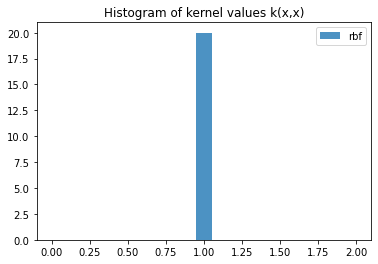

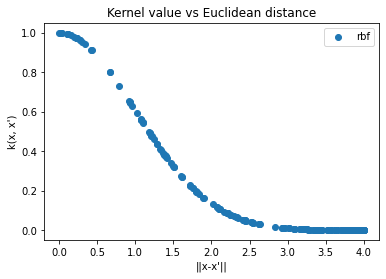

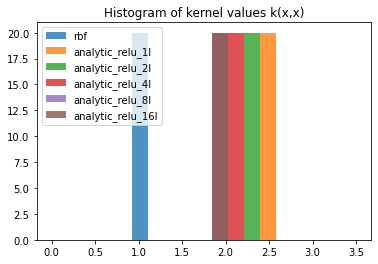

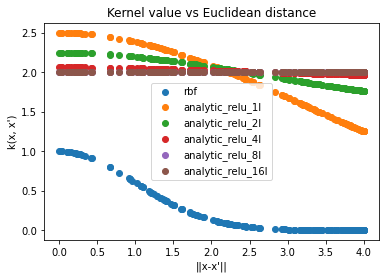

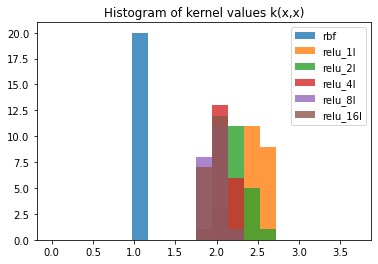

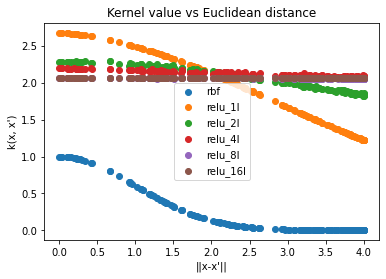

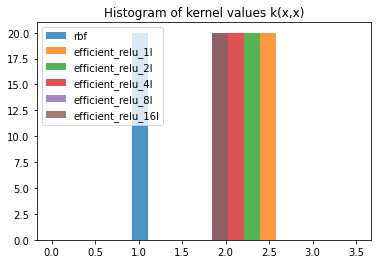

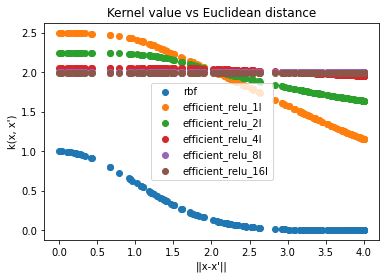

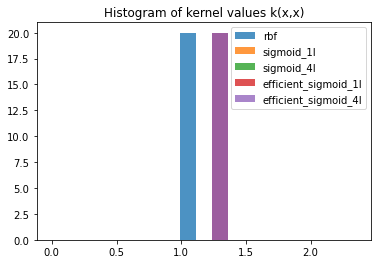

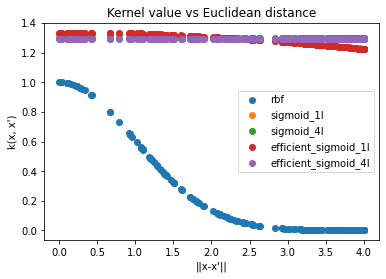

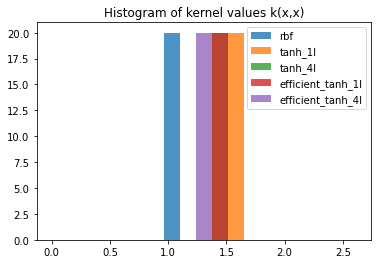

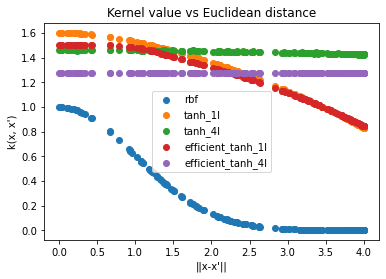

In [18]:
kernels_tmp = [k for k in kernels_sphere if k['name'] in ['rbf']]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_sphere, kernels_tmp)

kernels_tmp = [k for k in kernels_sphere if k['name'] in ['rbf'] or k['name'].startswith('analytic')]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_sphere, kernels_tmp)

kernels_tmp = [k for k in kernels_sphere if k['name'] in ['rbf'] or \
               (k['name'].startswith('relu') and k['kernel_params']['num_samples'] == 1000)]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_sphere, kernels_tmp)

kernels_tmp = [k for k in kernels_sphere if k['name'] in ['rbf'] or k['name'].startswith('efficient_relu')]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_sphere, kernels_tmp)

kernels_tmp = [k for k in kernels_sphere if k['name'] in ['rbf'] or 'sigmoid' in k['name']]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_sphere, kernels_tmp)

kernels_tmp = [k for k in kernels_sphere if k['name'] in ['rbf'] or 'tanh' in k['name']]
plot_stationarity_properties(kernels_tmp, num_bins=20)
kernel_val_vs_distance(X_sphere, kernels_tmp)

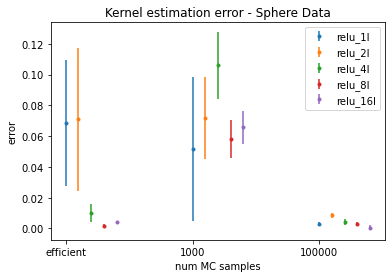

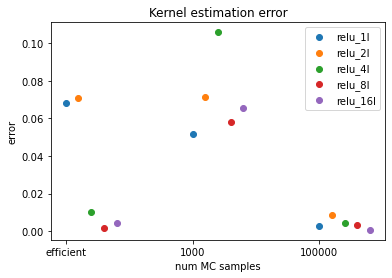

In [19]:
kernels_relu_1l = [k for k in kernels_sphere if 'relu_1l' in k['name']]
relu_1l_errs = kernel_estimation_error('relu_1l', kernels_relu_1l, show_plots=False)

kernels_relu_2l = [k for k in kernels_sphere if 'relu_2l' in k['name']]
relu_2l_errs = kernel_estimation_error('relu_2l', kernels_relu_2l, show_plots=False)

kernels_relu_4l = [k for k in kernels_sphere if 'relu_4l' in k['name']]
relu_4l_errs = kernel_estimation_error('relu_4l', kernels_relu_4l, show_plots=False)

kernels_relu_8l = [k for k in kernels_sphere if 'relu_8l' in k['name']]
relu_8l_errs = kernel_estimation_error('relu_8l', kernels_relu_8l, show_plots=False)

kernels_relu_16l = [k for k in kernels_sphere if 'relu_16l' in k['name']]
relu_16l_errs = kernel_estimation_error('relu_16l', kernels_relu_16l, show_plots=False)

errs = [('relu_1l', relu_1l_errs), ('relu_2l', relu_2l_errs),
        ('relu_4l', relu_4l_errs), ('relu_8l', relu_8l_errs),
        ('relu_16l', relu_16l_errs)]

plt.title('Kernel estimation error - Sphere Data')
for i, err in enumerate(errs):
    sizes = [j + i/10 for j, _ in enumerate(err[1][0])]
    plt.errorbar(sizes, err[1][1], yerr=err[1][2], label=err[0], fmt='.')
plt.xlabel('num MC samples')
plt.ylabel('error')
plt.legend()
plt.xticks([0, 1, 2], [str(s) if s != -1 else 'efficient' for s in errs[0][1][0]])
plt.show()

plt.title('Kernel estimation error')
for i, err in enumerate(errs):
    sizes = [j + i/10 for j, _ in enumerate(err[1][0])]
    plt.scatter(sizes, err[1][1], label=err[0])
plt.xlabel('num MC samples')
plt.ylabel('error')
plt.legend()
plt.xticks([0, 1, 2], [str(s) if s != -1 else 'efficient' for s in errs[0][1][0]])
plt.show()


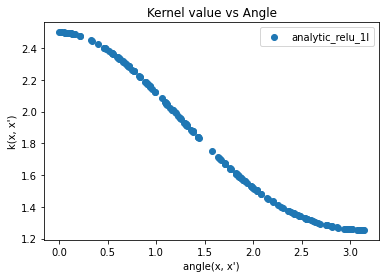

In [20]:
def kernel_val_vs_angle(data, kernel_dicts):
    if isinstance(data, torch.Tensor):
        data = data.detach().cpu().numpy()
    costheta = 1 - cdist(data, data, 'cosine')
    edits = np.arccos(costheta)
    
    triu_inds = np.triu_indices(edits.shape[0], k=1)
    triu_edits = edits[triu_inds]
    sorted_inds = np.argsort(triu_edits)

    plt.title('Kernel value vs Angle')
    for i, k in enumerate(kernel_dicts):
        plt.scatter(triu_edits[sorted_inds], k['kernel'][triu_inds][sorted_inds], label=k['name'])
    plt.legend()
    plt.ylabel('k(x, x\')')
    plt.xlabel('angle(x, x\')')
    plt.show()

kernels_relu1l = [k for k in kernels_sphere if k['name'] == 'analytic_relu_1l'][0]
kernel_val_vs_angle(X_sphere, [kernels_relu1l])